In [1]:
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import ngboost as ngb
import numpy as np
import torch
from torch import nn
from torch import optim
from tqdm import tqdm

from models.flow import build_model

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [2]:
from math import log, pi

def gaussian_log_likelihood(x, mean, logvar, clip=True):
    if clip:
        logvar = torch.clamp(logvar, min=-4, max=3)
    a = log(2 * pi)
    b = logvar
    c = (x - mean) ** 2 / torch.exp(logvar)
    return -0.5 * (a + b + c)

In [3]:
def _generate_data(n=100, std=0.05):
    eps = std * np.random.randn(n)
    x = np.random.rand(n) * 2*np.pi # - 2*np.pi
    y = np.sin(x) + eps
    return x, y


def generate_data(n=100, std=0.05):
    x1, y1 = _generate_data(n=n, std=std)
    x2, y2 = _generate_data(n=n, std=std)
    y2 = -y2
    return np.concatenate([x1, x2]).reshape(-1, 1), np.concatenate([y1, y2])

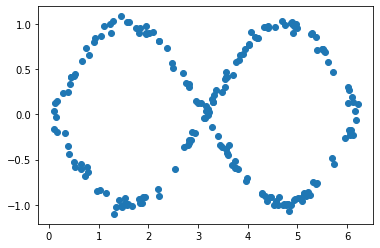

In [4]:
x, y = generate_data()

plt.scatter(x, y)
plt.show()

In [5]:
model = ngb.NGBRegressor()

In [6]:
model.fit(x, y)

[iter 0] loss=1.0765 val_loss=0.0000 scale=1.0000 norm=0.7646
[iter 100] loss=0.7794 val_loss=0.0000 scale=2.0000 norm=1.2492
[iter 200] loss=0.5969 val_loss=0.0000 scale=2.0000 norm=1.0962
[iter 300] loss=0.4581 val_loss=0.0000 scale=2.0000 norm=0.9982
[iter 400] loss=0.3531 val_loss=0.0000 scale=1.0000 norm=0.4691


NGBRegressor(random_state=RandomState(MT19937) at 0x7FD9B5399360)

In [7]:
x_sort = np.sort(x)

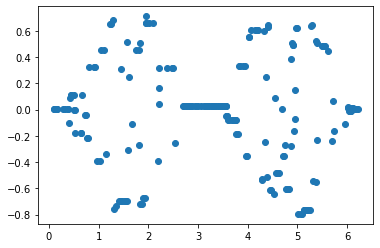

In [8]:
y_hat = model.predict(x_sort)

plt.scatter(x_sort, y_hat)
plt.show()

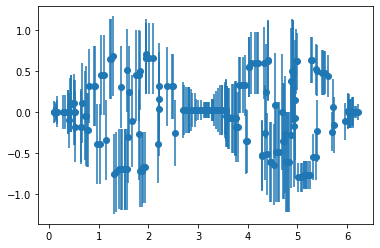

In [9]:
y_params = model.pred_param(x_sort)

plt.errorbar(x_sort, y_params[:, 0], yerr=np.exp(y_params[:, 1]), fmt='o')
plt.show()

In [10]:
x, y = generate_data()
x, y = torch.Tensor(x).to(DEVICE), torch.Tensor(y).to(DEVICE)
x, y = x.reshape(-1), y.reshape(-1, 1)

In [11]:
flow = build_model(
    input_dim=1,
    hidden_dims=(100,),
    context_dim=1,
    conditional=True,
    time_length=1.0,
    batch_norm=True,
    layer_type="concatscale"
).to(DEVICE)

optimizer = optim.Adam(flow.parameters())

Loss 0.20:   0%|          | 0/2000 [00:00<?, ?it/s]

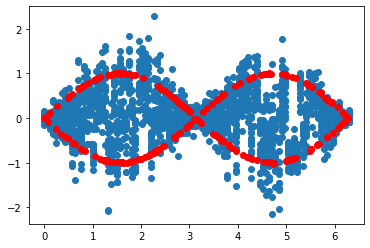

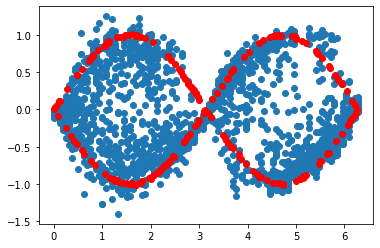

Loss 0.06:  10%|█         | 200/2000 [04:41<44:39,  1.49s/it] 

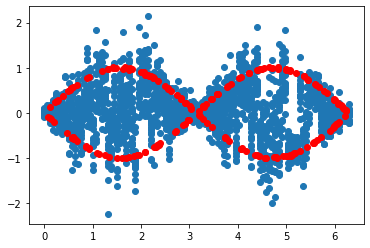

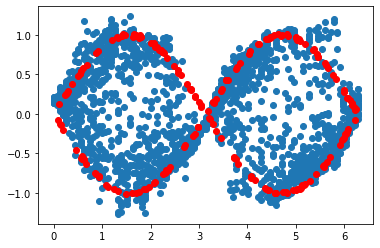

Loss 0.17:  20%|██        | 400/2000 [07:57<23:26,  1.14it/s] 

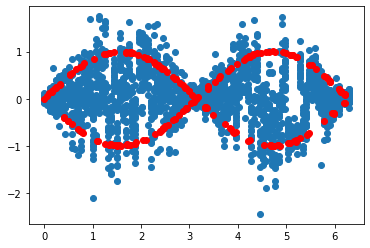

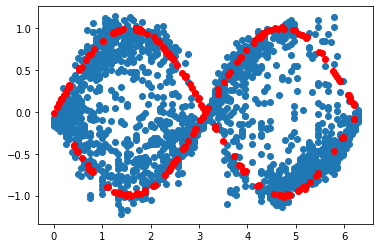

Loss 0.58:  30%|███       | 600/2000 [12:45<33:53,  1.45s/it] 

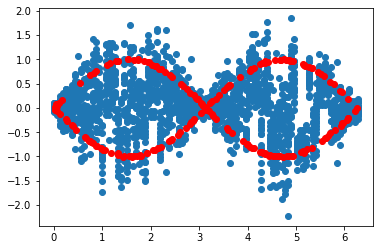

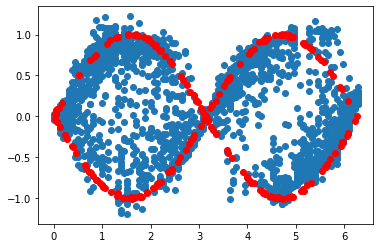

Loss 0.05:  40%|████      | 800/2000 [17:50<30:44,  1.54s/it] 

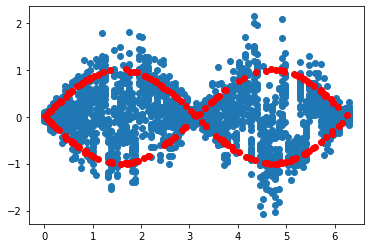

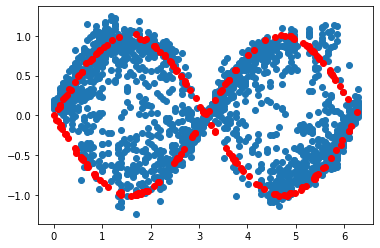

Loss 0.61:  50%|█████     | 1000/2000 [23:05<26:06,  1.57s/it]

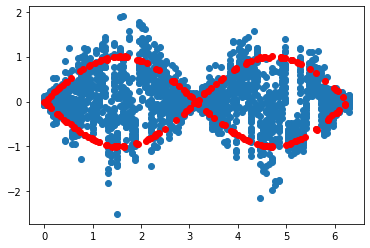

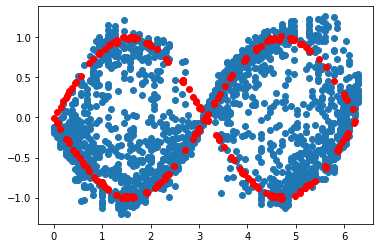

Loss 0.60:  60%|██████    | 1200/2000 [26:41<13:50,  1.04s/it] 

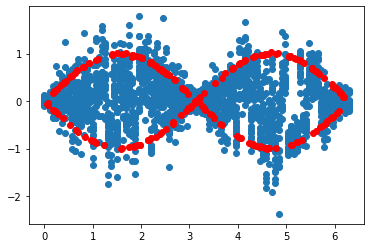

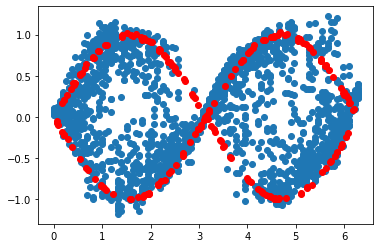

Loss 0.77:  70%|███████   | 1400/2000 [30:09<10:42,  1.07s/it] 

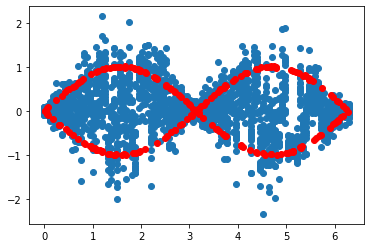

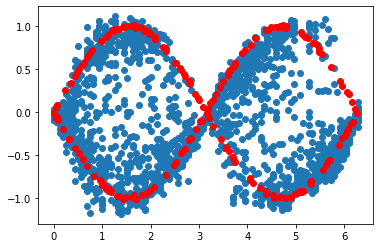

Loss 0.49:  80%|████████  | 1600/2000 [33:44<07:00,  1.05s/it] 

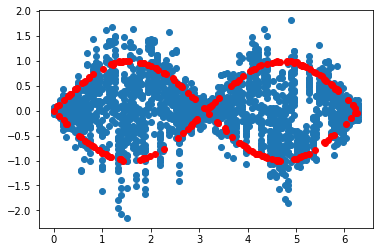

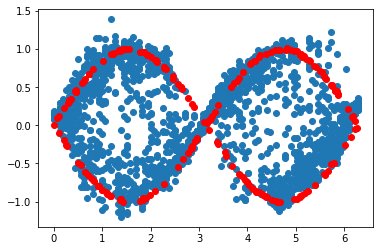

Loss -0.19:  90%|█████████ | 1800/2000 [37:24<03:41,  1.11s/it]

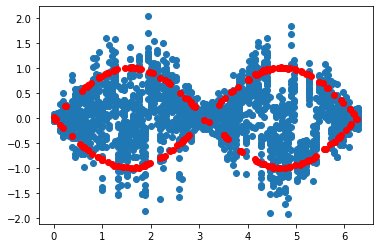

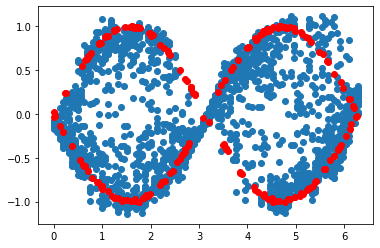

Loss 0.27: 100%|██████████| 2000/2000 [41:08<00:00,  1.23s/it] 


In [14]:
num_iter = 2000

with tqdm(range(num_iter)) as pbar:
    for i in pbar:
        x, y = generate_data()
        y_params = model.pred_param(x)
        
        x, y = torch.Tensor(x).to(DEVICE), torch.Tensor(y).to(DEVICE)
        x, y = x.reshape(-1), y.reshape(-1, 1)
        y_params = torch.Tensor(y_params).to(DEVICE)
        
        optimizer.zero_grad()

        zero = torch.zeros(y.shape[0], 1).to(DEVICE)
        z, delta_logp = flow(x=y, context=x, logpx=zero)  # run model forward

        logpz = gaussian_log_likelihood(z, mean=y_params[:, 0].reshape(-1, 1), logvar=y_params[:, 1].reshape(-1, 1))
        logpx = logpz - delta_logp

        loss = -logpx.mean()
        pbar.set_description(f"Loss {loss:.2f}")

        loss.backward()
        optimizer.step()
        
        if i % 200 == 0:
            n_samples = 20

            x, y = generate_data(std=0.01)

            x_new = torch.linspace(0, 2*np.pi, 101).repeat(n_samples).reshape(-1, 1)
            y_params = model.pred_param(x_new)
            y_samples = model.pred_dist(x_new).sample(1)

            # plt.errorbar(x_new, y_params[:, 0], yerr=np.exp(y_params[:, 1]), fmt='o')
            plt.scatter(x_new, y_samples)
            plt.scatter(x, y, c='red')
            plt.show()

            x_new = x_new.to(DEVICE)
            y_params = torch.Tensor(y_params).to(DEVICE)
            z = torch.randn(len(x_new), 1).to(DEVICE)
            z = (z + y_params[:, 0].reshape(-1, 1)) * y_params[:, 1].exp().reshape(-1, 1)

            y_new = flow(x=z, context=x_new, reverse=True)
            y_new = y_new.detach().cpu().numpy()

            plt.scatter(x_new.detach().cpu().numpy(), y_new)
            plt.scatter(x, y, c='red')
            plt.show()

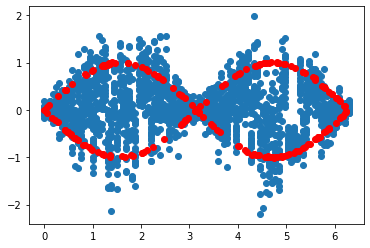

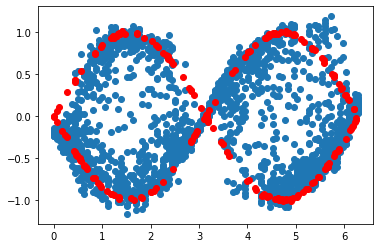

In [15]:
n_samples = 20

x, y = generate_data(std=0.01)

x_new = torch.linspace(0, 2*np.pi, 101).repeat(n_samples).reshape(-1, 1)
y_params = model.pred_param(x_new)
y_samples = model.pred_dist(x_new).sample(1)

# plt.errorbar(x_new, y_params[:, 0], yerr=np.exp(y_params[:, 1]), fmt='o')
plt.scatter(x_new, y_samples)
plt.scatter(x, y, c='red')
plt.show()

x_new = x_new.to(DEVICE)
y_params = torch.Tensor(y_params).to(DEVICE)
z = torch.randn(len(x_new), 1).to(DEVICE)
z = (z + y_params[:, 0].reshape(-1, 1)) * y_params[:, 1].exp().reshape(-1, 1)

y_new = flow(x=z, context=x_new, reverse=True)
y_new = y_new.detach().cpu().numpy()

plt.scatter(x_new.detach().cpu().numpy(), y_new)
plt.scatter(x, y, c='red')
plt.show()